# Run with sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import sys
import re
from concurrent.futures import ProcessPoolExecutor

In [2]:
import re

base_dir = "./Data" 
nex_dir = "./Nex"
# allen_data_dir = "/scratch/09656/dhh3/deeplabcut_data/"
allen_data_dir = "/scratch/09117/xz6783/Xu/Spectrum_cat_odor/deeplabcut_data/"


databin = 0.01
BinSize = 0.3 
TimeRange_before = 6 
TimeRange_after = 6.3 
Bins = int((TimeRange_before+TimeRange_after)/BinSize) 
Bins_before = int(TimeRange_before/BinSize)

## New data formatting

In [8]:
def parse_file(file_path):
    """Parses a text file and extracts data for each category."""
    category_data = {}
    current_category = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.endswith(':'):  # New category
                current_category = line[:-1]  # Remove the colon
            elif line:  # Cue data line
                cues = re.findall(r'\((\d+\.\d+)', line)  # Extract cue onsets
                if cues:
                    cues = [float(cue) for cue in cues]
                    category_data[current_category] = cues

    return category_data

def create_dataframes(category_data, animal_name):
    """Creates a DataFrame for each category, including MAX, MIN, and DIFF."""
    dataframes = {}

    for category, cues in category_data.items():
        df = pd.DataFrame(cues, columns=[animal_name])
        df['Cues'] = range(1, len(cues) + 1)  # Cue index
        df['MAX'] = df[animal_name].apply(max)
        df['MIN'] = df[animal_name].apply(min)
        df['DIFF'] = df['MAX'] - df['MIN']
        df = df[['Cues', animal_name, 'MAX', 'MIN', 'DIFF']]
        dataframes[category] = df

    return dataframes

def create_dataframes(all_animal_data):
    """Creates a DataFrame for each category, combining data and padding missing cues."""
    dataframes = {}

    for category, animal_data in all_animal_data.items():
        # Filter animals with more than 6 cues
#         filtered_animal_data = {animal: cues for animal, cues in animal_data.items() if len(cues) >= 6}
        
        if not animal_data:
            continue
        
        max_cues = max(len(cues) for cues in animal_data.values()) 

        padded_data = {
            animal: cues + [np.NaN] * (max_cues - len(cues)) 
            for animal, cues in animal_data.items()
        }

        df = pd.DataFrame(padded_data)
        df['Cues'] = range(1, max_cues + 1) 
        df['MAX'] = df.max(axis=1, skipna=True)
        df['MIN'] = df.min(axis=1, skipna=True)
        df['DIFF'] = df['MAX'] - df['MIN']
        df = df[['Cues'] + [col for col in df if col not in ['Cues', 'MAX', 'MIN', 'DIFF']] + ['MAX', 'MIN', 'DIFF']]

        dataframes[category] = df

    return dataframes

all_animal_data = {}  

for filename in os.listdir(allen_data_dir):
    if filename.endswith("Results.txt"):
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, filename)
        if match and match.group():
            animal_name = match.group()
#         animal_name = os.path.splitext(filename)[0]
        file_path = os.path.join(allen_data_dir, filename)

        category_data = parse_file(file_path)

        for category, cues in category_data.items():
            if category not in all_animal_data:
                all_animal_data[category] = {}
            all_animal_data[category][animal_name] = cues 
            
# Create combined DataFrames
dataframes = create_dataframes(all_animal_data)

# Example usage (print Freezing DataFrame)
print(dataframes["Risk Assessment"])

# Save as csv
for category, df in dataframes.items():
    csv_filename = f"allen_data_{category}.csv"
    csv_path = os.path.join(base_dir, csv_filename)
    df.to_csv(csv_path, index=False)  # Save DataFrame to CSV without row index
    

     Cues       3K3       4K3      10Z3       5A5       1P4       5A4  \
0       1   108.733  1066.400  1154.667  1319.400   605.800   556.467   
1       2   883.267  1095.133  1187.067  1569.933   618.267  1036.400   
2       3  1129.600  1124.667  1219.933  1706.200   687.533  1054.667   
3       4  1156.933  1139.467  1233.667  1849.467  1120.133  1299.133   
4       5  1191.600  1155.333  1244.267  1982.467  1202.467  1368.467   
..    ...       ...       ...       ...       ...       ...       ...   
103   104       NaN       NaN       NaN       NaN       NaN       NaN   
104   105       NaN       NaN       NaN       NaN       NaN       NaN   
105   106       NaN       NaN       NaN       NaN       NaN       NaN   
106   107       NaN       NaN       NaN       NaN       NaN       NaN   
107   108       NaN       NaN       NaN       NaN       NaN       NaN   

          3P4       1K3       2A4  ...       2K3      3U5       9F2       5P4  \
0     121.467   230.600   233.467  ...  12

## Code for calculating zscore, only run when needed (run with nex environment)

In [1]:
from nex5file.reader import Reader
from nex5file.filedata import FileData
import nex5file
import nex
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os
import subprocess
import time
import pandas as pd
import pickle
import math
import multiprocessing
from functools import partial
import random

In [2]:
base_dir = "./Data"
nex_dir = "./Nex"
# allen_data_dir = "/scratch/09656/dhh3/deeplabcut_data/"
allen_data_dir = "/scratch/09117/xz6783/Xu/Spectrum_cat_odor/deeplabcut_data/"


databin = 0.01
BinSize = 0.3
TimeRange_before = 6
TimeRange_after = 6.3
Bins = int((TimeRange_before+TimeRange_after)/BinSize)
Bins_before = int(TimeRange_before/BinSize) 

In [3]:
Bins_before

20

In [4]:
import re


filenames = os.listdir(nex_dir)

# Regular expression pattern to match number+letter+number before an underscore
pattern = r'\d{1,2}[A-Za-z]\d{1,2}'

# Extract and store animal IDs
animal_ids = [re.search(pattern, filename.split('_')[0]).group() for filename in filenames if re.search(pattern, filename)]

len(animal_ids)

30

In [6]:
# Load the csv file with cross timepoints
# interval_data = pd.read_csv(os.path.join(base_dir,"Trial by Trial Cues.csv"), header = 1)
# animal_ids = [os.path.splitext(filename)[0][:3] for filename in os.listdir(allen_data_dir)]
behavior_str = "Freezing" # Switch behavior string between "Avoidance", "Escape", "Freezing", "Mesh", "Risk Assessment"
interval_data = pd.read_csv(os.path.join(base_dir,f"allen_data_{behavior_str}.csv"))
photoid = pd.read_csv(os.path.join(base_dir,"PhotoTags.csv"), index_col =0)

In [7]:
animal_ids

['1U1',
 '1A5',
 '3P4',
 '4P4',
 '6U5',
 '4K3',
 '1P4',
 '2A5',
 '5A5',
 '5U5',
 '1K3',
 '4A4',
 '5A4',
 '6A4',
 '5M4',
 '9F2',
 '5P4',
 '3K3',
 '4A5',
 '2A4',
 '7U5',
 '10Z3',
 '6P4',
 '9L1',
 '2K3',
 '1D6',
 '2P4',
 '2L4',
 '3U5',
 '4U5']

In [8]:
def read_nex_events(nex_dir, event_name):
    neuron_data = {}
    nex_files = [file for file in os.listdir(nex_dir) if file.endswith('.nex')]
    reader = Reader()


    for nex_file in nex_files:
        file_path = os.path.join(nex_dir, nex_file)
        
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, nex_file.split('_')[0])
        if match and match.group() in animal_ids:
            animal_id = match.group()

            # Read only headers first to get neuron names
            variabelnames = reader.ReadNexHeadersOnly(file_path)

            # Filter neuron names based on photoid DataFrame
            spk_names = photoid[photoid['Animal_ID'] == animal_id]['Unit_id'].tolist()
            neuron_names = [name for name in variabelnames.NeuronNames() if name in spk_names]

            # Read only the relevant neuron variables
            fileData = reader.ReadNexFileVariables(file_path, event_name)

            # Get timestamps for each relevant neuron and store them
            for variable in fileData.variables:
                timestamps = variable.timestamps
                neuron_data[(animal_id, variable.metadata['name'])] = timestamps
        else:
            print(f"Pattern not found in {nex_file}")

    return neuron_data


In [9]:
lever = read_nex_events(nex_dir, 'EVT08')

max_length = max(len(arr) for arr in lever.values())

# Create a dictionary to store padded arrays
padded_data = {}
for key, arr in lever.items():
    padded_data[key[0]] = np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame
lever_pd = pd.DataFrame(padded_data)
lever_pd

,1U1,1A5,3P4,4P4,6U5,4K3,1P4,2A5,5A5,5U5,...,7U5,10Z3,6P4,9L1,2K3,1D6,2P4,2L4,3U5,4U5
0,73.57170,77.914325,128.917125,2.410700,90.613775,127.586175,122.316525,58.533225,43.646375,73.171550,...,98.535975,27.117750,69.508400,67.434225,127.677750,9.719075,5.631925,95.171625,39.710300,54.014450
1,76.37295,80.497475,200.016200,41.594825,91.546575,182.429025,124.498500,122.364475,55.569525,75.589675,...,141.448525,29.216525,71.235600,128.452775,130.493175,23.338925,8.585100,96.965700,55.641175,55.936575
2,123.57960,88.200950,241.793100,44.182950,121.495275,183.318175,200.845075,236.129225,79.377925,79.108775,...,191.617050,32.993300,125.204500,190.991300,130.934250,23.925900,13.591350,99.642800,125.936325,131.220775
3,132.67715,128.486825,299.842325,45.868000,181.456825,241.415625,202.474100,292.770575,99.124925,84.749250,...,196.121700,34.280450,127.462625,221.633550,134.174475,81.386925,38.726900,101.325000,161.434925,138.080050
4,143.25370,192.689250,361.282850,47.056900,185.318500,294.003625,241.478825,357.695000,100.585800,104.586450,...,224.768825,79.689175,182.273900,238.443075,135.858650,85.122875,44.715825,103.752275,189.846450,190.255200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3365.586975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3366.832500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3578.105750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3642.825150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
cue = read_nex_events(nex_dir, 'EVT04')

max_length = max(len(arr) for arr in cue.values())

# Create a dictionary to store padded arrays
padded_data = {}
for key, arr in cue.items():
    padded_data[key[0]] = np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame
cue_pd = pd.DataFrame(padded_data)
cue_pd

,1U1,1A5,3P4,4P4,6U5,4K3,1P4,2A5,5A5,5U5,...,7U5,10Z3,6P4,9L1,2K3,1D6,2P4,2L4,3U5,4U5
0,119.938450,119.897475,119.893075,119.925875,119.886925,119.922450,119.896200,119.889150,119.875150,119.888325,...,119.890250,119.897475,119.884375,119.910050,119.924525,119.882350,119.895575,119.903100,119.928225,119.888550
1,179.938950,179.932300,179.895275,179.925100,179.885950,179.920750,179.895375,179.887900,179.874700,179.888375,...,179.889500,179.896650,179.884600,179.909900,179.924050,179.931600,179.894625,179.901850,179.928100,179.888625
2,234.938775,234.942175,234.895400,234.925250,234.886575,234.922075,234.895500,234.888525,234.874650,234.938725,...,234.919350,234.896775,234.884750,234.910025,234.924175,234.917525,234.894750,234.902850,234.927825,234.889275
3,289.939050,289.933125,289.896500,289.925325,289.887325,289.921650,289.895575,289.888475,289.874525,289.939250,...,289.940025,289.896925,289.884875,289.910725,289.924000,289.932125,289.894925,289.902700,289.928075,289.889375
4,354.939150,354.947325,354.895625,354.925550,354.936725,354.922225,354.895800,354.938925,354.874825,354.938100,...,354.939775,354.897150,354.885100,354.909800,354.924475,354.918800,354.895100,354.902175,354.928750,354.939275
5,424.939075,424.943500,424.895900,424.925675,424.936825,424.922125,424.895950,424.932900,424.874775,424.905300,...,424.939600,424.897350,424.885225,424.910500,424.924250,424.932400,424.895200,424.902425,424.965825,424.939650
6,479.938875,479.943800,479.892975,479.925875,479.911325,479.922475,479.896100,479.909125,479.875325,479.939125,...,479.940450,479.897525,479.885325,479.910700,479.924325,479.909150,479.895350,479.902750,479.971500,479.939725
7,544.938500,544.947775,544.896200,544.926075,544.937175,544.922475,544.896225,544.939325,544.874625,544.939225,...,544.906200,544.897675,544.884500,544.910600,544.924125,544.932400,544.895550,544.902900,544.963725,544.913000
8,599.939650,599.932325,599.891250,599.926125,599.921350,599.922050,599.896400,599.939675,599.875400,599.938750,...,599.910500,599.897875,599.884625,599.910850,599.924175,599.932950,599.895775,599.902425,599.974525,599.909775
9,654.939150,654.944375,654.896400,654.926375,654.902750,654.922700,654.896550,654.939675,654.875325,654.925925,...,654.934525,654.897975,654.885750,654.910950,654.925150,654.902025,654.895850,654.902850,654.966550,654.913750


In [11]:
dish = read_nex_events(nex_dir, 'EVT18')

max_length = max(len(arr) for arr in dish.values())

# Create a dictionary to store padded arrays
padded_data = {}
for key, arr in dish.items():
    padded_data[key[0]] = np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame
dish_pd = pd.DataFrame(padded_data)
dish_pd

,1U1,1A5,3P4,4P4,6U5,4K3,1P4,2A5,5A5,5U5,...,7U5,10Z3,6P4,9L1,2K3,1D6,2P4,2L4,3U5,4U5
0,26.512500,3.813425,24.912325,60.579175,88.412100,4.412350,55.146450,55.578825,21.345725,74.712100,...,9.113500,14.313625,2.779550,16.479525,18.312375,0.513300,4.412550,23.779250,38.412800,20.313125
1,38.178825,18.013250,35.646325,65.212250,92.712400,15.146075,112.478575,57.678950,79.112300,77.578325,...,39.479500,16.479575,19.779625,34.712150,19.079400,4.046525,6.612600,45.379225,40.879850,53.211900
2,74.811675,20.579425,52.712500,66.446275,122.878700,22.246175,121.945625,59.212075,80.679275,79.978525,...,57.645675,17.945550,24.179800,66.378400,24.078750,4.679550,9.712575,50.245600,43.045975,54.645925
3,124.477900,42.712725,84.045575,108.378300,123.912175,42.911975,124.411650,81.112525,97.578400,84.412800,...,81.112550,27.879650,26.879750,68.645175,28.411925,5.446575,12.179575,90.245700,48.046225,55.311975
4,129.478200,76.312400,85.678475,137.945650,151.145300,52.179375,168.044775,82.145825,106.944650,92.145825,...,97.778900,30.112625,43.379675,70.011675,30.045900,8.712825,27.646650,94.578975,52.712425,56.546250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3644.642625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3653.510150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3659.409300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3707.075425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
first_press = {}
for name, value in cue_pd.iteritems():
    firstbar = np.array([], dtype = 'int64')
    for i in value:
        diff = lever_pd[name] - i
        if len(diff[diff>0]) > 0:
            firstbarindex = lever_pd[name][list(diff).index(min(diff[diff>0]))]
            if firstbarindex < i+15:
                firstbar = np.append(firstbar, firstbarindex)

    first_press[name] = firstbar

In [13]:
first_press.items()

dict_items([('1U1', array([123.5796  , 190.085525, 238.043825, 291.526475, 368.41335 ,
       427.3981  , 483.19595 , 553.443025, 610.408375, 660.55695 ,
       735.220075, 783.870725])), ('1A5', array([128.486825, 192.68925 , 236.779625, 298.136575, 366.4443  ,
       550.19925 , 600.539125, 668.715475, 792.6125  ])), ('3P4', array([128.917125, 241.7931  , 299.842325, 361.28285 , 429.695725,
       490.8025  , 559.0846  , 603.014975, 729.791525, 792.024375])), ('4P4', array([185.16235 , 238.30335 , 294.22965 , 360.122625, 425.568575,
       483.399075, 547.49775 , 606.42555 , 664.909875, 732.148675,
       782.3377  ])), ('6U5', array([121.495275, 181.456825, 241.5799  , 294.846675, 355.616325,
       433.132125, 486.3377  , 548.821325, 602.28805 , 658.3846  ,
       729.1107  ])), ('4K3', array([127.586175, 182.429025, 241.415625, 294.003625, 358.56945 ,
       430.408775, 486.413025, 548.46175 , 606.0113  , 656.35025 ,
       735.704825, 788.6586  ])), ('1P4', array([122.316525, 241

In [14]:

max_length = max(len(arr) for arr in first_press.values())

# Create a dictionary to store padded arrays
padded_data = {}
for key, arr in first_press.items():
    padded_data[key] = np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame
first_press_pd = pd.DataFrame(padded_data)
first_press_pd

,1U1,1A5,3P4,4P4,6U5,4K3,1P4,2A5,5A5,5U5,...,7U5,10Z3,6P4,9L1,2K3,1D6,2P4,2L4,3U5,4U5
0,123.579600,128.486825,128.917125,185.162350,121.495275,127.586175,122.316525,122.364475,122.915300,134.098125,...,191.617050,123.772700,125.204500,128.452775,127.677750,123.059750,128.447125,130.874725,125.936325,131.220775
1,190.085525,192.689250,241.793100,238.303350,181.456825,182.429025,241.478825,236.129225,184.255925,245.167625,...,242.226525,183.732600,182.273900,190.991300,182.200250,180.525225,187.405050,185.452875,189.846450,190.255200
2,238.043825,236.779625,299.842325,294.229650,241.579900,241.415625,292.296400,292.770575,247.299950,291.514475,...,427.319650,240.305850,239.189175,238.443075,237.375000,245.744050,246.114125,245.104775,293.798625,243.954625
3,291.526475,298.136575,361.282850,360.122625,294.846675,294.003625,356.810325,357.695000,291.150275,358.201250,...,485.000100,291.032925,294.252125,293.014175,292.653750,357.784650,294.521050,299.298975,358.025550,294.138875
4,368.413350,366.444300,429.695725,425.568575,355.616325,358.569450,427.009525,427.762500,429.934050,429.094425,...,559.532450,357.983275,360.244475,427.134300,356.102550,428.314975,355.927600,360.055100,430.681225,357.630700
5,427.398100,550.199250,490.802500,483.399075,433.132125,430.408775,483.659600,482.092000,484.612675,485.502675,...,606.723625,427.695775,427.332300,552.867125,428.415275,485.331200,427.393850,429.463225,489.611625,429.557125
6,483.195950,600.539125,559.084600,547.497750,486.337700,486.413025,657.353275,548.387675,557.737175,547.718925,...,657.085575,481.385300,481.899500,612.227400,481.148900,548.976975,485.831400,489.902700,613.040025,482.774850
7,553.443025,668.715475,603.014975,606.425550,548.821325,548.461750,730.109300,603.688950,600.780900,603.240675,...,727.456350,547.493850,552.200625,655.968300,546.566925,603.292725,554.693325,547.970075,659.043800,552.878400
8,610.408375,792.612500,729.791525,664.909875,602.288050,606.011300,785.407550,658.569075,657.747900,656.712000,...,794.029925,604.051900,657.825925,729.667650,612.011650,656.100150,610.874650,614.097950,733.176250,613.584750
9,660.556950,NaN,792.024375,732.148675,658.384600,656.350250,NaN,728.034275,727.009125,727.795025,...,NaN,660.504600,728.004050,785.000400,658.781375,727.137225,658.112425,658.276550,785.677300,656.876375


In [15]:
first_dish = {}
for name, value in first_press_pd.iteritems():
    firstbar = np.array([], dtype = 'int64')
    for i in value:
        diff = dish_pd[name] - i
        if len(diff[diff>0]) > 0:
            firstbarindex = dish_pd[name][list(diff).index(min(diff[diff>0]))]
            if firstbarindex < i+15:
                firstbar = np.append(firstbar, firstbarindex)

    first_dish[name] = firstbar

In [16]:
first_dish.items()

dict_items([('1U1', array([124.4779  , 191.043825, 238.943775, 292.30975 , 369.2428  ,
       428.67485 , 484.17415 , 554.40725 , 611.24005 , 661.53915 ,
       736.1394  , 784.73755 ])), ('1A5', array([129.211675, 193.3779  , 237.844125, 299.21015 , 367.27605 ,
       551.107475, 601.2736  , 669.806625, 796.13825 ])), ('3P4', array([129.71155 , 242.677825, 300.6101  , 362.00915 , 430.4753  ,
       491.574625, 560.273725, 603.90685 , 730.873075, 792.838275])), ('4P4', array([186.277525, 239.410675, 295.543825, 361.209025, 426.576175,
       484.47545 , 548.474575, 607.54065 , 666.040075, 733.1061  ,
       783.472125])), ('6U5', array([122.8787  , 182.64455 , 242.876875, 295.977325, 356.476375,
       434.44175 , 487.77505 , 549.708175, 603.674025, 662.040075,
       730.73945 ])), ('4K3', array([128.244725, 182.977   , 241.9106  , 294.909925, 359.10945 ,
       430.841525, 487.1081  , 549.040775, 606.639525, 657.205925,
       736.372125, 789.60415 ])), ('1P4', array([124.41165 , 243

In [17]:

max_length = max(len(arr) for arr in first_dish.values())

# Create a dictionary to store padded arrays
padded_data = {}
for key, arr in first_dish.items():
    padded_data[key] = np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=np.nan)

# Convert the dictionary to a DataFrame
first_dish_pd = pd.DataFrame(padded_data)
first_dish_pd

,1U1,1A5,3P4,4P4,6U5,4K3,1P4,2A5,5A5,5U5,...,7U5,10Z3,6P4,9L1,2K3,1D6,2P4,2L4,3U5,4U5
0,124.477900,129.211675,129.711550,186.277525,122.878700,128.244725,124.411650,123.311825,124.378275,135.344625,...,192.644750,125.079100,125.979050,129.277850,128.478150,123.911925,129.211875,134.312250,126.978950,132.011275
1,191.043825,193.377900,242.677825,239.410675,182.644550,182.977000,243.110900,237.011150,185.977600,246.143975,...,243.077200,184.611150,182.911025,191.810450,183.210400,181.378100,188.011400,186.844550,190.611150,191.077925
2,238.943775,237.844125,300.610100,295.543825,242.876875,241.910600,295.777050,294.609850,247.976975,292.809850,...,428.574975,241.010225,240.044125,239.342725,237.977575,246.643475,247.344200,246.043750,294.476800,245.444325
3,292.309750,299.210150,362.009150,361.209025,295.977325,294.909925,358.676175,360.142825,291.877025,359.075775,...,486.008550,292.043450,295.143300,293.807125,293.776450,358.642375,295.510475,301.176775,358.709350,295.243050
4,369.242800,367.276050,430.475300,426.576175,356.476375,359.109450,428.808725,429.975650,431.108425,430.208950,...,560.574925,359.142550,361.276450,428.006400,356.909725,429.609000,356.675475,361.542875,431.342575,358.242450
5,428.674850,551.107475,491.574625,484.475450,434.441750,430.841525,659.172950,483.941800,485.741125,486.307800,...,608.107325,428.441800,428.375800,553.670750,429.208550,486.141900,428.108875,430.708125,490.374575,430.375450
6,484.174150,601.273600,560.273725,548.474575,487.775050,487.108100,731.639150,549.141000,559.207775,548.540900,...,657.906400,482.142000,482.941750,613.103075,481.907500,549.740850,487.007925,492.974175,613.773750,483.874875
7,554.407250,669.806625,603.906850,607.540650,549.708175,549.040775,787.072300,606.107275,602.040025,604.640425,...,728.639425,548.507125,552.908025,656.802225,547.440300,604.540575,555.941025,549.007525,659.906475,553.807400
8,611.240050,796.138250,730.873075,666.040075,603.674025,606.639525,NaN,660.506350,658.806075,657.672675,...,795.771925,604.707300,658.473200,730.468575,612.839800,657.472600,611.940200,615.240375,733.872425,614.140125
9,661.539150,NaN,792.838275,733.106100,662.040075,657.205925,NaN,729.472800,728.339425,728.506150,...,NaN,661.240150,728.772400,785.934225,659.739550,728.271825,659.173325,659.872725,786.771550,657.473350


In [18]:
first_dish_pd.to_csv("first_dish_after_lever.csv")

In [19]:
def read_nex_files(nex_dir):
    neuron_data = {}
    nex_files = [file for file in os.listdir(nex_dir) if file.endswith('.nex')]
    reader = Reader()
    
    # Get columns of allen_animal_ids to use for matching
    allen_animal_ids = interval_data.columns.drop(['Cues', 'MAX', 'MIN', 'DIFF']).tolist()
    print(f"animal_ids: {allen_animal_ids}")

    for nex_file in nex_files:
        file_path = os.path.join(nex_dir, nex_file)
        
        # Extract animal ID from filename
        pattern = r'\d{1,2}[A-Za-z]\d{1,2}'
        match = re.search(pattern, nex_file.split('_')[0])
        if match and match.group() in allen_animal_ids:
            animal_id = match.group()

            # Read only headers first to get neuron names
            variabelnames = reader.ReadNexHeadersOnly(file_path)

            # Filter neuron names based on photoid DataFrame
            spk_names = photoid[photoid['Animal_ID'] == animal_id]['Unit_id'].tolist()
            neuron_names = [name for name in variabelnames.NeuronNames() if name in spk_names]

            # Read only the relevant neuron variables
            fileData = reader.ReadNexFileVariables(file_path, neuron_names)

            # Get timestamps for each relevant neuron and store them
            for variable in fileData.variables:
                timestamps = variable.timestamps
                neuron_data[(animal_id, variable.metadata['name'])] = timestamps
        else:
            print(f"Pattern not found in {nex_file}")

    return neuron_data




In [20]:
neuron_data = read_nex_files(nex_dir)
neuron_data

animal_ids: ['3K3', '4K3', '10Z3', '5A5', '1P4', '5A4', '3P4', '1K3', '2A4', '2P4', '6A4', '5U5', '2A5', '4A5', '5M4', '1U1', '6U5', '1A5', '4U5', '2L4', '7U5', '9L1', '4A4', '2K3', '3U5', '9F2', '5P4', '4P4', '6P4', '1D6']


{('1U1',
  'SPK01a'): array([1.57800000e-01, 5.98200000e-01, 6.78200000e-01, ...,
        3.35959312e+03, 3.35962195e+03, 3.35997590e+03]),
 ('1U1',
  'SPK02a'): array([2.98150000e-01, 6.36075000e-01, 7.84200000e-01, ...,
        3.35928670e+03, 3.35937010e+03, 3.35944758e+03]),
 ('1U1',
  'SPK08a'): array([1.30575000e-01, 1.53975000e-01, 5.89225000e-01, ...,
        3.35843408e+03, 3.35878010e+03, 3.35933395e+03]),
 ('1U1',
  'SPK09a'): array([8.37500000e-03, 2.22395000e+00, 2.56545000e+00, ...,
        3.35415430e+03, 3.35720718e+03, 3.35749190e+03]),
 ('1U1',
  'SPK12a'): array([1.24250000e-02, 4.94750000e-02, 1.52250000e-01, ...,
        3.35908957e+03, 3.35960280e+03, 3.35999008e+03]),
 ('1U1',
  'SPK24a'): array([6.70750000e-02, 7.72750000e-02, 1.16200000e-01, ...,
        3.35915767e+03, 3.35938360e+03, 3.35967908e+03]),
 ('1U1',
  'SPK25a'): array([2.59000000e-01, 4.04375000e-01, 5.89825000e-01, ...,
        3.35935842e+03, 3.35946823e+03, 3.35958887e+03]),
 ('1U1',
  'SPK26a')

In [21]:
interval_data = first_dish_pd

In [22]:
def calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization='Counts/Bin'):
         
    # Number of bins
    num_bins = int(np.ceil(round((XMax - XMin) / Bin,1)))
    bin_edges = np.linspace(XMin, XMax, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    # Check if there are enough events
    if len(events_timestamps) <= 6:
        return np.full(num_bins, np.nan)  # Fill with nulls (NaN)

    # Iterate over each reference event
    for ref in events_timestamps:
        # Calculate distances and filter out-of-range spikes
        distances = spike_timestamps - ref
        distances = distances[(distances >= XMin) & (distances < XMax)]

        # Use numpy histogram to count spikes in bins
        counts, _ = np.histogram(distances, bins=bin_edges)
        bin_counts += counts

    # Normalize if required
    if normalization == 'Spikes/Sec':
        bin_counts = bin_counts / (len(events_timestamps) * Bin)

    return bin_counts

# Set up correct range
def calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Counts/Bin'):
    spike_timestamps = neuron_data[neuron_id]
    animal_id = neuron_id[0]  # Assuming the first element of the tuple is the animal ID
    if cue_range is not None:
        # Compare cue_range with interval_data -> select interval_data within the range
        # e.g. Cue range 0 = 0, cue range 1 = 600
#         events_timestamps = interval_data[animal_id][cue_range[0]:cue_range[1]].to_numpy()
        mask = (interval_data[animal_id] > cue_range[0]) & (interval_data[animal_id] < cue_range[1])
        events_timestamps = interval_data[animal_id][mask].to_numpy()
        print(events_timestamps)
    else:
        events_timestamps = interval_data[animal_id].to_numpy()

    firing_rates = calculate_perievent_firing_rates(spike_timestamps, events_timestamps, XMin, XMax, Bin, normalization)
    return neuron_id, firing_rates

# Function to be executed in parallel
def process_neuron_data(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization):
    return calculate_neuron_firing_rates(neuron_id, neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization)


def parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, cue_range, normalization='Spikes/Sec'):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    func = partial(process_neuron_data, neuron_data=neuron_data, interval_data=interval_data, XMin=XMin, XMax=XMax, Bin=Bin, cue_range = cue_range, normalization=normalization)
    results = pool.map(func, neuron_data.keys())
    pool.close()
    pool.join()

    # Create a DataFrame from the results
    columns = ['AnimalID', 'NeuronID'] + [f'{i}' for i in range(int(np.ceil(round((XMax - XMin) / Bin,1))))]
    data = []
    for (animal_id, neuron_id), firing_rates in results:
        row = [animal_id, neuron_id] + firing_rates.tolist()
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    return df

# Example usage
XMin = -6  # Define your XMin
XMax = 6.3   # Define your XMax
Bin = 0.3  # Define your Bin size
# reward_cue = (0,12) #for freezing etc. changed it to based on time instead. first 600s reward, last 600s conflict.
reward_cue = None

cue_firing_rates_df = parallel_firing_rates_calculation(neuron_data, interval_data, XMin, XMax, Bin, reward_cue)

# Display the DataFrame
print(cue_firing_rates_df.head())



  AnimalID NeuronID         0         1         2         3         4  \
0      1U1   SPK01a  1.764706  3.137255  2.745098  2.156863  3.137255   
1      1U1   SPK02a  2.156863  2.352941  2.745098  2.745098  2.352941   
2      1U1   SPK08a  1.960784  2.941176  6.274510  4.313725  4.705882   
3      1U1   SPK09a  1.176471  0.980392  0.784314  0.392157  0.588235   
4      1U1   SPK12a  3.921569  5.882353  5.098039  3.921569  5.098039   

          5         6         7  ...        31        32        33        34  \
0  3.529412  3.725490  3.137255  ...  1.764706  2.745098  3.921569  2.352941   
1  2.156863  1.764706  1.960784  ...  2.941176  2.745098  3.137255  2.941176   
2  2.352941  1.764706  1.764706  ...  3.137255  1.764706  2.745098  1.960784   
3  0.588235  2.745098  2.352941  ...  0.588235  0.784314  0.784314  0.588235   
4  4.705882  2.941176  3.921569  ...  5.686275  5.098039  5.098039  4.705882   

         35        36        37        38        39        40  
0  2.941176  1.9

In [23]:
cue_firing_rates_df

,AnimalID,NeuronID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,1.764706,3.137255,2.745098,2.156863,3.137255,3.529412,3.725490,3.137255,...,1.764706,2.745098,3.921569,2.352941,2.941176,1.960784,2.941176,4.313725,2.549020,3.529412
1,1U1,SPK02a,2.156863,2.352941,2.745098,2.745098,2.352941,2.156863,1.764706,1.960784,...,2.941176,2.745098,3.137255,2.941176,3.333333,1.764706,2.745098,2.941176,5.294118,5.686275
2,1U1,SPK08a,1.960784,2.941176,6.274510,4.313725,4.705882,2.352941,1.764706,1.764706,...,3.137255,1.764706,2.745098,1.960784,2.549020,1.176471,1.960784,2.941176,1.176471,2.549020
3,1U1,SPK09a,1.176471,0.980392,0.784314,0.392157,0.588235,0.588235,2.745098,2.352941,...,0.588235,0.784314,0.784314,0.588235,0.784314,0.588235,0.196078,0.196078,0.392157,1.372549
4,1U1,SPK12a,3.921569,5.882353,5.098039,3.921569,5.098039,4.705882,2.941176,3.921569,...,5.686275,5.098039,5.098039,4.705882,5.098039,2.941176,4.705882,5.686275,3.529412,5.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,4.117647,7.058824,3.725490,3.921569,3.137255,4.705882,7.058824,7.647059,...,3.725490,3.725490,3.529412,4.117647,4.313725,4.509804,4.313725,2.549020,1.764706,1.372549
409,4U5,SPK28a,3.333333,1.568627,2.745098,1.372549,3.137255,2.941176,2.549020,1.568627,...,3.725490,3.725490,3.529412,2.156863,2.156863,1.764706,2.549020,3.333333,3.529412,3.333333
410,4U5,SPK29a,4.901961,4.901961,7.058824,4.509804,6.078431,7.647059,6.666667,7.058824,...,6.078431,5.294118,4.313725,3.529412,3.921569,4.705882,7.647059,6.666667,6.470588,5.882353
411,4U5,SPK31a,1.176471,2.941176,1.960784,1.372549,0.784314,2.549020,1.568627,1.372549,...,3.725490,2.745098,1.372549,1.764706,2.156863,3.137255,2.549020,3.333333,1.568627,1.764706


In [24]:
# reward_cue_firing_rates_df.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/reward_cue_firing_rates_df_6s.csv', index= None)
# conflict_cue_firing_rates_df.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/conflict_cue_firing_rates_df_6s.csv', index= None)
behavior_str = 'dish'
cue_firing_rates_df.to_csv(f'Data/cue_firing_rates_df_6s_{behavior_str}.csv', index= None)
# conflict_cue_firing_rates_df.to_csv(f'Data/conflict_cue_firing_rates_df_6s_{behavior_str}.csv', index= None)

In [32]:
cue_firing_rates_df_6s = cue_firing_rates_df.iloc[:, int((-XMin-TimeRange_before)/BinSize)+2:int((XMax+TimeRange_after)/BinSize)+2]
baseline_mean = cue_firing_rates_df_6s.iloc[:, 0:Bins_before].mean(axis = 1)
baseline_std = cue_firing_rates_df_6s.iloc[:, 0:Bins_before].std(axis = 1)

cue_zscore = cue_firing_rates_df_6s.sub(baseline_mean, axis = 0).divide(baseline_std, axis = 0)
cue_zscore.columns =  np.arange(0, cue_firing_rates_df_6s.shape[1])
cue_zscore = cue_zscore.assign(AnimalID= cue_firing_rates_df.AnimalID, NeuronID= cue_firing_rates_df.NeuronID)
columns = ['AnimalID', 'NeuronID'] + [col for col in cue_zscore.columns if col not in ['AnimalID', 'NeuronID']]
cue_zscore = cue_zscore[columns]
# cue_zscore.to_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/tone_responses_PL_nex_file_updated_by_code_6s.csv', index= None)
cue_zscore.to_csv(f'Data/{behavior_str}_PL_nex_file_updated_by_code_6s.csv', index= None)

cue_zscore


,AnimalID,NeuronID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,-1.453444,5.031153e-01,-0.055902,-0.894427,0.503115,1.062132,1.341641,0.503115,...,-1.453444,-0.055902,1.621149,-0.614919,0.223607,-1.173936,0.223607,2.180166,-0.335410,1.062132
1,1U1,SPK02a,0.907185,1.162730e+00,1.673821,1.673821,1.162730,0.907185,0.396095,0.651640,...,1.929366,1.673821,2.184911,1.929366,2.440456,0.396095,1.673821,1.929366,4.995907,5.506998
2,1U1,SPK08a,-0.395790,3.371548e-01,2.829169,1.363278,1.656456,-0.102612,-0.542380,-0.542380,...,0.483744,-0.542380,0.190566,-0.395790,0.043977,-0.982147,-0.395790,0.337155,-0.982147,0.043977
3,1U1,SPK09a,0.299370,-3.390153e-16,-0.299370,-0.898111,-0.598741,-0.598741,2.694334,2.095593,...,-0.598741,-0.299370,-0.299370,-0.598741,-0.299370,-0.598741,-1.197482,-1.197482,-0.898111,0.598741
4,1U1,SPK12a,-0.392410,1.391270e+00,0.677798,-0.392410,0.677798,0.321062,-1.284249,-0.392410,...,1.212902,0.677798,0.677798,0.321062,0.677798,-1.284249,0.321062,1.212902,-0.749146,0.856166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,-0.860858,1.248573e-01,-0.992287,-0.926573,-1.189430,-0.663715,0.124857,0.322000,...,-0.992287,-0.992287,-1.058001,-0.860858,-0.795144,-0.729429,-0.795144,-1.386573,-1.649431,-1.780859
409,4U5,SPK28a,0.666120,-1.123456e+00,0.069595,-1.322297,0.467278,0.268436,-0.129247,-1.123456,...,1.063803,1.063803,0.864961,-0.526931,-0.526931,-0.924614,-0.129247,0.666120,0.864961,0.666120
410,4U5,SPK29a,-1.042550,-1.042550e+00,-0.009392,-1.230397,-0.479010,0.272378,-0.197239,-0.009392,...,-0.479010,-0.854704,-1.324321,-1.700015,-1.512168,-1.136474,0.272378,-0.197239,-0.291163,-0.572933
411,4U5,SPK31a,-0.601228,1.975464e+00,0.543968,-0.314929,-1.173827,1.402866,-0.028630,-0.314929,...,3.120661,1.689165,-0.314929,0.257669,0.830268,2.261763,1.402866,2.548063,-0.028630,0.257669


## Responsive cells (with sklearn)

In [3]:
behavior_str = 'dish'

In [4]:

reward_headindish_zscore = pd.read_csv(f'Data/{behavior_str}_PL_nex_file_updated_by_code_6s.csv')

reward_headindish_zscore = reward_headindish_zscore.replace([np.inf, -np.inf], np.nan)


In [5]:
reward_headindish_zscore

,AnimalID,NeuronID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,-1.453444,5.031153e-01,-0.055902,-0.894427,0.503115,1.062132,1.341641,0.503115,...,-1.453444,-0.055902,1.621149,-0.614919,0.223607,-1.173936,0.223607,2.180166,-0.335410,1.062132
1,1U1,SPK02a,0.907185,1.162730e+00,1.673821,1.673821,1.162730,0.907185,0.396095,0.651640,...,1.929366,1.673821,2.184911,1.929366,2.440456,0.396095,1.673821,1.929366,4.995907,5.506998
2,1U1,SPK08a,-0.395790,3.371548e-01,2.829169,1.363278,1.656456,-0.102612,-0.542380,-0.542380,...,0.483744,-0.542380,0.190566,-0.395790,0.043977,-0.982147,-0.395790,0.337155,-0.982147,0.043977
3,1U1,SPK09a,0.299370,-3.390153e-16,-0.299370,-0.898111,-0.598741,-0.598741,2.694334,2.095593,...,-0.598741,-0.299370,-0.299370,-0.598741,-0.299370,-0.598741,-1.197482,-1.197482,-0.898111,0.598741
4,1U1,SPK12a,-0.392410,1.391270e+00,0.677798,-0.392410,0.677798,0.321062,-1.284249,-0.392410,...,1.212902,0.677798,0.677798,0.321062,0.677798,-1.284249,0.321062,1.212902,-0.749146,0.856166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,-0.860858,1.248573e-01,-0.992287,-0.926573,-1.189430,-0.663715,0.124857,0.322000,...,-0.992287,-0.992287,-1.058001,-0.860858,-0.795144,-0.729429,-0.795144,-1.386573,-1.649431,-1.780859
409,4U5,SPK28a,0.666120,-1.123456e+00,0.069595,-1.322297,0.467278,0.268436,-0.129247,-1.123456,...,1.063803,1.063803,0.864961,-0.526931,-0.526931,-0.924614,-0.129247,0.666120,0.864961,0.666120
410,4U5,SPK29a,-1.042550,-1.042550e+00,-0.009392,-1.230397,-0.479010,0.272378,-0.197239,-0.009392,...,-0.479010,-0.854704,-1.324321,-1.700015,-1.512168,-1.136474,0.272378,-0.197239,-0.291163,-0.572933
411,4U5,SPK31a,-0.601228,1.975464e+00,0.543968,-0.314929,-1.173827,1.402866,-0.028630,-0.314929,...,3.120661,1.689165,-0.314929,0.257669,0.830268,2.261763,1.402866,2.548063,-0.028630,0.257669


In [6]:
XMin = -6 
XMax = 6.3
Bin = 0.3
excited_reward_headindish = reward_headindish_zscore[(reward_headindish_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]>1.96).any(axis =1)].iloc[:,2:]
inhibited_reward_headindish = reward_headindish_zscore[(reward_headindish_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]<-1.65).any(axis =1)].iloc[:,2:]

In [7]:
excited_reward_headindish_indices = excited_reward_headindish.index.values
inhibited_reward_headindish_indices = inhibited_reward_headindish.index.values
excited_reward_headindish_mean = excited_reward_headindish.mean(axis=0).astype('float')
excited_reward_headindish_sem = excited_reward_headindish.sem(axis=0).astype('float')
inhibited_reward_headindish_mean = inhibited_reward_headindish.mean(axis=0).astype('float')
inhibited_reward_headindish_sem = inhibited_reward_headindish.sem(axis=0).astype('float')

53

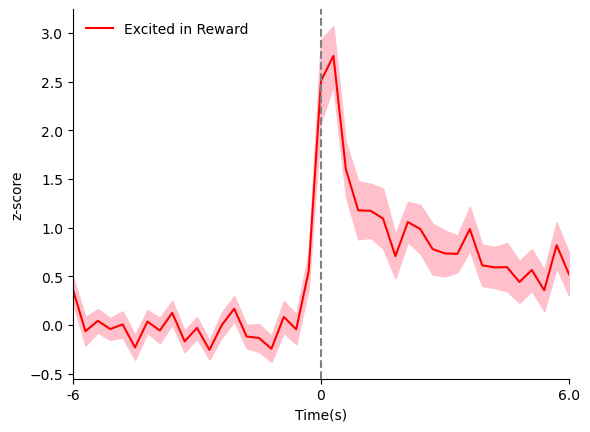

In [8]:
x=np.arange(Bins)
y=excited_reward_headindish_mean
err = excited_reward_headindish_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Reward', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_reward_headindish)

56

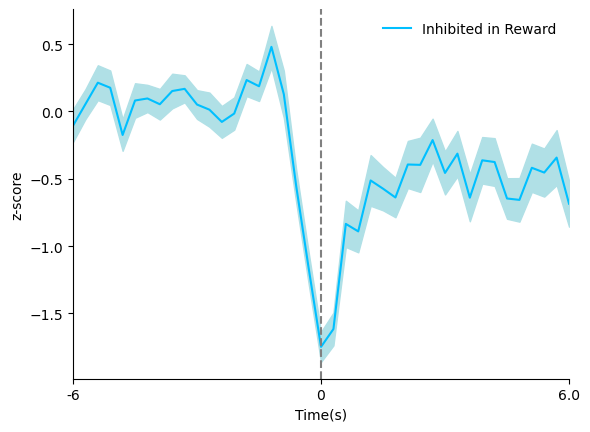

In [9]:
x=np.arange(Bins)
y=inhibited_reward_headindish_mean
err = inhibited_reward_headindish_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Reward', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward_headindish)

In [10]:
behavior_str = 'lever'

In [11]:
# reward_cue_zscore = pd.read_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv')
# conflict_cue_zscore = pd.read_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Conflict_tone_responses_PL_nex_file_updated_by_code_6s.csv') 

reward_lever_zscore = pd.read_csv(f'Data/{behavior_str}_PL_nex_file_updated_by_code_6s.csv')

reward_lever_zscore = reward_lever_zscore.replace([np.inf, -np.inf], np.nan)


In [12]:
reward_lever_zscore

,AnimalID,NeuronID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,-0.106671,-0.716217,0.198103,-1.020991,-0.411444,0.502876,-0.411444,0.807650,...,0.502876,1.112423,-0.106671,-0.716217,-1.325764,2.636290,0.807650,-0.716217,-1.020991,1.417196
1,1U1,SPK02a,0.526910,1.279639,0.777820,1.279639,0.777820,1.279639,0.777820,1.028729,...,1.530548,1.279639,0.025091,2.032367,1.530548,1.530548,2.283277,1.530548,1.028729,1.028729
2,1U1,SPK08a,0.132277,-0.645825,-0.023343,-0.490204,-0.023343,2.933444,1.688481,1.066000,...,2.466583,1.688481,-0.334584,0.132277,-0.178963,-0.178963,-0.645825,0.132277,-1.423927,-0.178963
3,1U1,SPK09a,0.164490,-0.109660,0.712790,0.438640,0.164490,-0.109660,-0.932110,-1.206260,...,-0.109660,0.712790,-0.109660,-0.109660,-0.657960,-0.383810,-0.657960,-0.383810,-0.932110,-0.932110
4,1U1,SPK12a,0.611415,1.851967,-0.097472,-0.451916,0.788637,0.611415,0.079750,-0.097472,...,0.611415,-0.097472,1.497524,0.079750,1.674746,-0.097472,0.611415,0.256972,-1.515246,-0.274694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,-1.187663,-0.087126,-0.087126,-0.453972,-0.178837,-0.270549,-1.004240,-0.912529,...,-0.729106,-0.270549,-0.912529,-1.095952,-0.820817,0.004586,-0.729106,-0.453972,-0.362260,-1.646220
409,4U5,SPK28a,1.019476,-1.575554,0.092680,-1.019476,-0.648757,0.648757,-1.019476,0.648757,...,-0.834117,-0.648757,0.092680,-0.092680,0.463398,0.278039,-0.648757,-0.092680,-0.648757,-0.463398
410,4U5,SPK29a,-0.577824,-0.925387,-1.186060,-1.012278,-0.404042,-0.230261,-0.056479,-0.751606,...,1.159993,-0.664715,-1.012278,-0.925387,-0.925387,-0.925387,-1.707405,-1.359842,-1.186060,0.725539
411,4U5,SPK31a,1.084738,0.710691,-1.533595,0.710691,0.336643,1.832833,-1.159548,0.710691,...,2.580929,2.580929,1.458786,3.703072,0.336643,0.710691,2.206881,2.206881,1.832833,4.077119


In [13]:
XMin = -6 
XMax = 6.3
Bin = 0.3
excited_reward_lever = reward_lever_zscore[(reward_lever_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]>1.96).any(axis =1)].iloc[:,2:]
inhibited_reward_lever = reward_lever_zscore[(reward_lever_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]<-1.65).any(axis =1)].iloc[:,2:]

In [14]:
excited_reward_lever_indices = excited_reward_lever.index.values
inhibited_reward_lever_indices = inhibited_reward_lever.index.values
excited_reward_lever_mean = excited_reward_lever.mean(axis=0).astype('float')
excited_reward_lever_sem = excited_reward_lever.sem(axis=0).astype('float')
inhibited_reward_lever_mean = inhibited_reward_lever.mean(axis=0).astype('float')
inhibited_reward_lever_sem = inhibited_reward_lever.sem(axis=0).astype('float')

85

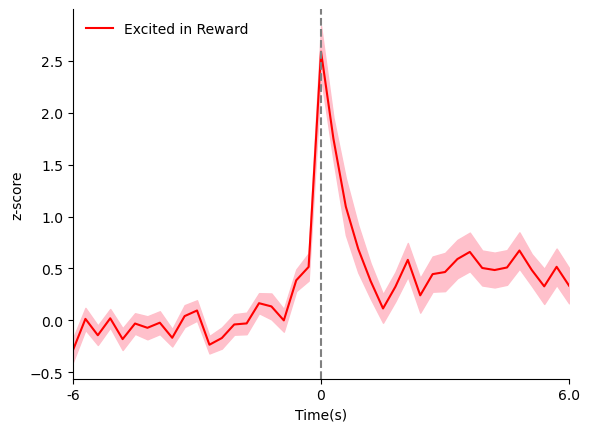

In [15]:
x=np.arange(Bins)
y=excited_reward_lever_mean
err = excited_reward_lever_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Reward', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_reward_lever)

60

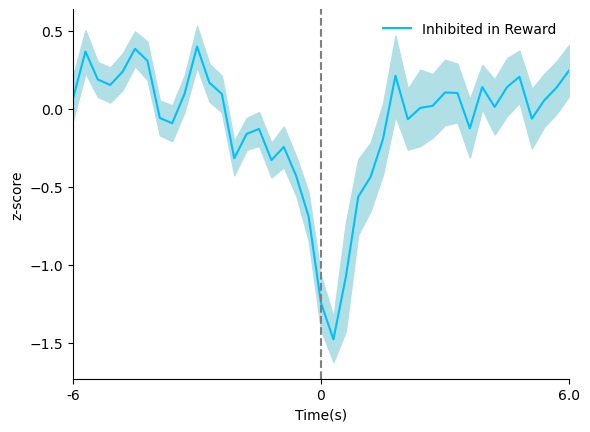

In [16]:
x=np.arange(Bins)
y=inhibited_reward_lever_mean
err = inhibited_reward_lever_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Reward', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward_lever)

In [17]:
reward_cue_zscore = pd.read_csv('/scratch/09117/xz6783/Xu/Spectrum_cat_odor/Data/Reward_tone_responses_PL_nex_file_updated_by_code_6s.csv')
reward_cue_zscore = reward_cue_zscore.replace([np.inf, -np.inf], np.nan)


In [18]:
reward_cue_zscore

,AnimalID,NeuronID,0,1,2,3,4,5,6,7,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,-1.488847,1.245770,-2.096540,-0.577308,-0.273462,-0.881155,0.030385,0.030385,...,1.853463,-0.273462,3.676542,-0.881155,0.030385,1.853463,0.941924,0.334231,0.334231,1.549617
1,1U1,SPK02a,0.999463,-0.999463,-0.713902,1.856146,0.428341,-0.142780,0.428341,-0.999463,...,-0.142780,-1.285024,-1.285024,-1.285024,-0.713902,-0.999463,-1.856146,-1.856146,-0.428341,0.142780
2,1U1,SPK08a,-0.230109,-0.830393,-0.030014,-0.630299,-0.830393,-1.030488,-1.430678,-0.830393,...,0.170081,-0.230109,0.370175,-0.030014,2.371123,2.571218,0.570270,-0.030014,0.170081,-0.830393
3,1U1,SPK09a,0.968963,0.472059,-1.018653,0.472059,1.465867,-0.024845,-0.521749,-1.515557,...,-1.018653,-0.024845,0.968963,-0.024845,1.465867,1.465867,0.968963,-0.521749,-2.012461,1.465867
4,1U1,SPK12a,0.263228,0.582291,-0.215368,-0.055836,0.263228,0.103696,-0.693963,0.901355,...,-0.215368,0.263228,-0.055836,0.422759,1.539482,1.220419,1.379950,1.060887,-0.693963,-0.374900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,-1.653239,-1.090434,-0.386928,0.597980,0.316578,-0.809032,-0.809032,2.004992,...,2.849199,1.301486,-0.246227,-0.949733,-0.668331,0.879382,2.004992,1.864291,1.160785,1.020084
409,4U5,SPK28a,0.141526,0.656166,1.942767,-0.115794,0.141526,0.398846,-0.887754,-1.402394,...,1.685447,1.685447,0.913486,0.656166,1.685447,1.685447,-0.115794,-0.373114,2.972047,0.913486
410,4U5,SPK29a,2.733850,0.069279,-0.889967,-0.570218,1.028524,1.135107,1.028524,0.495610,...,-0.676801,4.119426,2.307518,2.414101,0.389027,-0.357052,0.175862,0.495610,1.881187,1.668021
411,4U5,SPK31a,-1.335982,-0.043096,-0.905020,0.172385,-0.905020,-0.043096,-0.474058,0.387866,...,0.172385,-1.551463,-1.120501,-0.689539,-1.766944,-0.689539,-1.335982,-0.043096,1.680752,-0.043096


In [19]:
XMin = -6 
XMax = 6.3
Bin = 0.3
excited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]>1.96).any(axis =1)].iloc[:,2:]
inhibited_reward = reward_cue_zscore[(reward_cue_zscore.iloc[:,2+Bins_before:2+Bins_before+int((0.6)/BinSize)]<-1.65).any(axis =1)].iloc[:,2:]

In [20]:
excited_reward_indices = excited_reward.index.values
inhibited_reward_indices = inhibited_reward.index.values
excited_reward_mean = excited_reward.mean(axis=0).astype('float')
excited_reward_sem = excited_reward.sem(axis=0).astype('float')
inhibited_reward_mean = inhibited_reward.mean(axis=0).astype('float')
inhibited_reward_sem = inhibited_reward.sem(axis=0).astype('float')

68

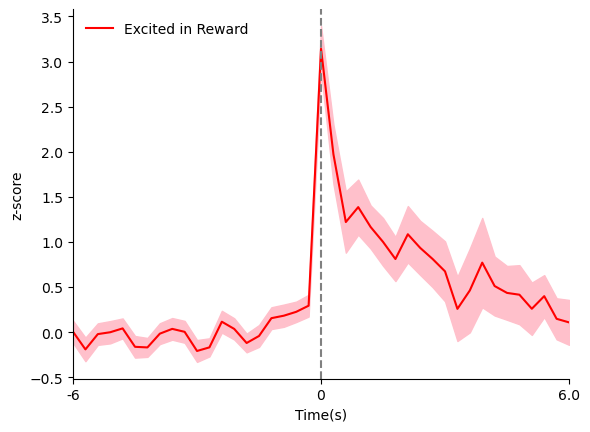

In [21]:
x=np.arange(Bins)
y=excited_reward_mean
err = excited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Excited in Reward', color = 'red')
ax.fill_between(x, y-err, y+err, color='pink')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc = 2, framealpha = 0)
len(excited_reward)

66

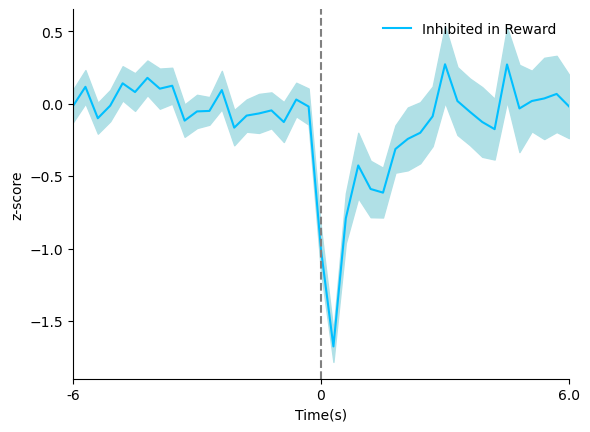

In [22]:
x=np.arange(Bins)
y=inhibited_reward_mean
err = inhibited_reward_sem
fig, ax = plt.subplots()
ax.plot(x, y, label = 'Inhibited in Reward', color = 'deepskyblue', linestyle = '-')
ax.fill_between(x, y-err, y+err, color='powderblue')
ax.set_xlabel('Time(s)')
ax.set_ylabel('z-score')
ax.set_xticks([0,Bins_before,Bins-1])
ax.set_xticklabels([-TimeRange_before,'0',TimeRange_after-0.3])
ax.set_xlim(0, Bins-1)
# ax.set_ylim(-,1)
ax.axvline(Bins_before, color = 'grey', ls = '--')
ax.legend(loc = 0, framealpha = 0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
len(inhibited_reward)

In [23]:
cue_cells = np.append(excited_reward_indices, inhibited_reward_indices)

In [24]:
lever_cells = np.append(excited_reward_lever_indices, inhibited_reward_lever_indices)

In [25]:
headindish_cells = np.append(excited_reward_headindish_indices, inhibited_reward_headindish_indices)

## Phototagged

In [26]:
photoid = pd.read_csv(os.path.join(base_dir,"Phototag ID's updated by code.csv"), index_col =0)
photoid.index = ["Unit", "PL GABA", "PL-PVT", "PL-NAc"]

In [27]:
PhotoTag = pd.DataFrame(columns=['AnimalID', 'NeuronID', 'Unit_Type'])

photoid = photoid.reset_index()
# Iterate over the columns in the input DataFrame
current_animal_id = None
for col in photoid.columns[1:]:
    if 'Unnamed' not in col:
        current_animal_id = col
    for row_idx in range(1, photoid.shape[0]):
        unit_id = photoid.loc[0, col]
        unit_type = photoid.loc[row_idx, 'index']
        value = photoid.loc[row_idx, col]

        if value == "1":
            new_row = pd.DataFrame({'AnimalID': [current_animal_id], 'NeuronID': [unit_id], 'Unit_Type': [unit_type]})
            PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)

    # Check if the current column has all 0s
    if pd.to_numeric(photoid.loc[1:, col], errors='coerce').sum() == 0:
        new_row = pd.DataFrame({'AnimalID': [current_animal_id], 'NeuronID': [unit_id], 'Unit_Type': ['Unidentified']})
        PhotoTag = pd.concat([PhotoTag, new_row], ignore_index=True)


In [28]:
PhotoTag

,AnimalID,NeuronID,Unit_Type
0,1U1,SPK01a,Unidentified
1,1U1,SPK02a,Unidentified
2,1U1,SPK08a,Unidentified
3,1U1,SPK09a,Unidentified
4,1U1,SPK12a,Unidentified
...,...,...,...
408,1D6,SPK14a,Unidentified
409,1D6,SPK16a,PL-NAc
410,1D6,SPK21a,Unidentified
411,1D6,SPK29a,PL-NAc


In [52]:
reward_cue_zscore_tagged =  reward_cue_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)
columns = ['AnimalID', 'NeuronID', 'Unit_Type', '_merge'] + [col for col in reward_cue_zscore_tagged.columns if col not in ['AnimalID', 'NeuronID', 'Unit_Type', '_merge']]
reward_cue_zscore_tagged = reward_cue_zscore_tagged[columns]
reward_cue_zscore_tagged

,AnimalID,NeuronID,Unit_Type,_merge,0,1,2,3,4,5,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,Unidentified,both,-1.488847,1.245770,-2.096540,-0.577308,-0.273462,-0.881155,...,1.853463,-0.273462,3.676542,-0.881155,0.030385,1.853463,0.941924,0.334231,0.334231,1.549617
1,1U1,SPK02a,Unidentified,both,0.999463,-0.999463,-0.713902,1.856146,0.428341,-0.142780,...,-0.142780,-1.285024,-1.285024,-1.285024,-0.713902,-0.999463,-1.856146,-1.856146,-0.428341,0.142780
2,1U1,SPK08a,Unidentified,both,-0.230109,-0.830393,-0.030014,-0.630299,-0.830393,-1.030488,...,0.170081,-0.230109,0.370175,-0.030014,2.371123,2.571218,0.570270,-0.030014,0.170081,-0.830393
3,1U1,SPK09a,Unidentified,both,0.968963,0.472059,-1.018653,0.472059,1.465867,-0.024845,...,-1.018653,-0.024845,0.968963,-0.024845,1.465867,1.465867,0.968963,-0.521749,-2.012461,1.465867
4,1U1,SPK12a,Unidentified,both,0.263228,0.582291,-0.215368,-0.055836,0.263228,0.103696,...,-0.215368,0.263228,-0.055836,0.422759,1.539482,1.220419,1.379950,1.060887,-0.693963,-0.374900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,PL-PVT,both,-1.653239,-1.090434,-0.386928,0.597980,0.316578,-0.809032,...,2.849199,1.301486,-0.246227,-0.949733,-0.668331,0.879382,2.004992,1.864291,1.160785,1.020084
409,4U5,SPK28a,Unidentified,both,0.141526,0.656166,1.942767,-0.115794,0.141526,0.398846,...,1.685447,1.685447,0.913486,0.656166,1.685447,1.685447,-0.115794,-0.373114,2.972047,0.913486
410,4U5,SPK29a,PL-PVT,both,2.733850,0.069279,-0.889967,-0.570218,1.028524,1.135107,...,-0.676801,4.119426,2.307518,2.414101,0.389027,-0.357052,0.175862,0.495610,1.881187,1.668021
411,4U5,SPK31a,PL-PVT,both,-1.335982,-0.043096,-0.905020,0.172385,-0.905020,-0.043096,...,0.172385,-1.551463,-1.120501,-0.689539,-1.766944,-0.689539,-1.335982,-0.043096,1.680752,-0.043096


In [53]:
reward_lever_zscore_tagged =  reward_lever_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)
columns = ['AnimalID', 'NeuronID', 'Unit_Type', '_merge'] + [col for col in reward_lever_zscore_tagged.columns if col not in ['AnimalID', 'NeuronID', 'Unit_Type', '_merge']]
reward_lever_zscore_tagged = reward_lever_zscore_tagged[columns]
reward_lever_zscore_tagged

,AnimalID,NeuronID,Unit_Type,_merge,0,1,2,3,4,5,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,Unidentified,both,-0.106671,-0.716217,0.198103,-1.020991,-0.411444,0.502876,...,0.502876,1.112423,-0.106671,-0.716217,-1.325764,2.636290,0.807650,-0.716217,-1.020991,1.417196
1,1U1,SPK02a,Unidentified,both,0.526910,1.279639,0.777820,1.279639,0.777820,1.279639,...,1.530548,1.279639,0.025091,2.032367,1.530548,1.530548,2.283277,1.530548,1.028729,1.028729
2,1U1,SPK08a,Unidentified,both,0.132277,-0.645825,-0.023343,-0.490204,-0.023343,2.933444,...,2.466583,1.688481,-0.334584,0.132277,-0.178963,-0.178963,-0.645825,0.132277,-1.423927,-0.178963
3,1U1,SPK09a,Unidentified,both,0.164490,-0.109660,0.712790,0.438640,0.164490,-0.109660,...,-0.109660,0.712790,-0.109660,-0.109660,-0.657960,-0.383810,-0.657960,-0.383810,-0.932110,-0.932110
4,1U1,SPK12a,Unidentified,both,0.611415,1.851967,-0.097472,-0.451916,0.788637,0.611415,...,0.611415,-0.097472,1.497524,0.079750,1.674746,-0.097472,0.611415,0.256972,-1.515246,-0.274694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,PL-PVT,both,-1.187663,-0.087126,-0.087126,-0.453972,-0.178837,-0.270549,...,-0.729106,-0.270549,-0.912529,-1.095952,-0.820817,0.004586,-0.729106,-0.453972,-0.362260,-1.646220
409,4U5,SPK28a,Unidentified,both,1.019476,-1.575554,0.092680,-1.019476,-0.648757,0.648757,...,-0.834117,-0.648757,0.092680,-0.092680,0.463398,0.278039,-0.648757,-0.092680,-0.648757,-0.463398
410,4U5,SPK29a,PL-PVT,both,-0.577824,-0.925387,-1.186060,-1.012278,-0.404042,-0.230261,...,1.159993,-0.664715,-1.012278,-0.925387,-0.925387,-0.925387,-1.707405,-1.359842,-1.186060,0.725539
411,4U5,SPK31a,PL-PVT,both,1.084738,0.710691,-1.533595,0.710691,0.336643,1.832833,...,2.580929,2.580929,1.458786,3.703072,0.336643,0.710691,2.206881,2.206881,1.832833,4.077119


In [54]:
reward_headindish_zscore_tagged =  reward_headindish_zscore.merge(PhotoTag, on=['AnimalID', 'NeuronID'], how = 'inner', indicator=True)
columns = ['AnimalID', 'NeuronID', 'Unit_Type', '_merge'] + [col for col in reward_headindish_zscore_tagged.columns if col not in ['AnimalID', 'NeuronID', 'Unit_Type', '_merge']]
reward_headindish_zscore_tagged = reward_headindish_zscore_tagged[columns]
reward_headindish_zscore_tagged

,AnimalID,NeuronID,Unit_Type,_merge,0,1,2,3,4,5,...,31,32,33,34,35,36,37,38,39,40
0,1U1,SPK01a,Unidentified,both,-1.453444,5.031153e-01,-0.055902,-0.894427,0.503115,1.062132,...,-1.453444,-0.055902,1.621149,-0.614919,0.223607,-1.173936,0.223607,2.180166,-0.335410,1.062132
1,1U1,SPK02a,Unidentified,both,0.907185,1.162730e+00,1.673821,1.673821,1.162730,0.907185,...,1.929366,1.673821,2.184911,1.929366,2.440456,0.396095,1.673821,1.929366,4.995907,5.506998
2,1U1,SPK08a,Unidentified,both,-0.395790,3.371548e-01,2.829169,1.363278,1.656456,-0.102612,...,0.483744,-0.542380,0.190566,-0.395790,0.043977,-0.982147,-0.395790,0.337155,-0.982147,0.043977
3,1U1,SPK09a,Unidentified,both,0.299370,-3.390153e-16,-0.299370,-0.898111,-0.598741,-0.598741,...,-0.598741,-0.299370,-0.299370,-0.598741,-0.299370,-0.598741,-1.197482,-1.197482,-0.898111,0.598741
4,1U1,SPK12a,Unidentified,both,-0.392410,1.391270e+00,0.677798,-0.392410,0.677798,0.321062,...,1.212902,0.677798,0.677798,0.321062,0.677798,-1.284249,0.321062,1.212902,-0.749146,0.856166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,4U5,SPK27a,PL-PVT,both,-0.860858,1.248573e-01,-0.992287,-0.926573,-1.189430,-0.663715,...,-0.992287,-0.992287,-1.058001,-0.860858,-0.795144,-0.729429,-0.795144,-1.386573,-1.649431,-1.780859
409,4U5,SPK28a,Unidentified,both,0.666120,-1.123456e+00,0.069595,-1.322297,0.467278,0.268436,...,1.063803,1.063803,0.864961,-0.526931,-0.526931,-0.924614,-0.129247,0.666120,0.864961,0.666120
410,4U5,SPK29a,PL-PVT,both,-1.042550,-1.042550e+00,-0.009392,-1.230397,-0.479010,0.272378,...,-0.479010,-0.854704,-1.324321,-1.700015,-1.512168,-1.136474,0.272378,-0.197239,-0.291163,-0.572933
411,4U5,SPK31a,PL-PVT,both,-0.601228,1.975464e+00,0.543968,-0.314929,-1.173827,1.402866,...,3.120661,1.689165,-0.314929,0.257669,0.830268,2.261763,1.402866,2.548063,-0.028630,0.257669


In [88]:
pvt_animals = np.array(['1P4', '10Z3', '2P4', '3U5', '1A5', '2A4', '4U5'])

In [89]:
pvt_indices = reward_cue_zscore_tagged[(reward_cue_zscore_tagged.Unit_Type == 'PL-PVT') & (reward_cue_zscore_tagged.AnimalID.isin(pvt_animals))].index.values
len(pvt_indices)

63

In [99]:
unidentified_indices = reward_cue_zscore_tagged[(reward_cue_zscore_tagged.Unit_Type == 'Unidentified') & (reward_cue_zscore_tagged.AnimalID.isin(pvt_animals))].index.values
len(unidentified_indices)

48

In [101]:
mask = np.ones(len(unidentified_indices), dtype=bool)
mask[4:11] = False
unidentified_indices = unidentified_indices[mask]
len(unidentified_indices)

41

In [102]:
reward_cue_zscore_tagged.iloc[unidentified_indices]

,AnimalID,NeuronID,Unit_Type,_merge,0,1,2,3,4,5,...,31,32,33,34,35,36,37,38,39,40
11,1A5,SPK04a,Unidentified,both,-0.467398,0.738791,1.643433,0.437244,-1.070493,-0.165851,...,-0.165851,-0.768946,-0.165851,-1.070493,-1.975136,-0.467398,0.135696,-0.467398,1.040339,-1.673588
13,1A5,SPK09a,Unidentified,both,0.775959,0.775959,2.327878,1.293265,-1.293265,-0.775959,...,-0.775959,-0.258653,-1.293265,-0.775959,-0.775959,0.775959,-0.258653,1.293265,0.258653,-0.775959
14,1A5,SPK09b,Unidentified,both,-0.404714,0.202357,-0.202357,1.416498,2.428282,0.809427,...,-1.416498,-1.011784,-1.821211,-2.225925,-2.630638,-0.809427,-0.607070,-1.011784,-0.404714,-0.607070
15,1A5,SPK10a,Unidentified,both,0.104630,1.499701,0.104630,0.802166,-0.592905,0.453398,...,-0.592905,1.150933,0.453398,0.453398,0.802166,-0.941673,0.104630,-1.290441,0.453398,-0.592905
96,1P4,SPK06a,Unidentified,both,-0.935219,0.400808,0.846151,0.846151,-0.489877,0.400808,...,1.736835,3.072863,-0.489877,-0.044534,0.400808,-0.044534,0.846151,-1.825904,1.736835,-0.044534
97,1P4,SPK08a,Unidentified,both,-0.967305,0.760025,0.414559,-0.967305,1.105491,-0.967305,...,-0.967305,-2.003703,0.069093,-1.658237,-1.658237,-1.312771,-1.312771,-2.003703,-1.658237,-0.621839
98,1P4,SPK14a,Unidentified,both,-0.876443,0.125206,-0.876443,-0.876443,0.626031,-0.375618,...,1.126855,-1.377267,0.125206,-0.876443,1.126855,0.125206,-0.375618,-0.876443,0.626031,-0.375618
100,1P4,SPK19a,Unidentified,both,0.559047,0.355757,-0.660692,-0.863982,-0.457402,0.152467,...,-0.457402,-0.457402,-0.457402,-1.067272,-1.067272,-1.270562,-1.067272,-0.863982,-1.067272,-1.677142
101,1P4,SPK20a,Unidentified,both,1.262189,-0.043524,-0.913999,-0.913999,-0.913999,-0.261143,...,-0.696380,-0.913999,-0.913999,-0.913999,-0.478761,-1.566855,-1.784474,-1.349236,-1.784474,-2.219711
281,2A4,SPK14b,Unidentified,both,-0.858956,-0.078087,-0.078087,-1.952172,1.171303,-0.390434,...,-1.952172,-1.483651,-2.733041,-0.546608,-1.639824,-1.015129,-1.483651,-2.264520,-2.576867,-1.327477


In [103]:
reward_cue_zscore_tagged.iloc[unidentified_indices].to_csv("reward_cue_zscore_pl_pvt_optrode_uidentified.csv")

In [104]:
cue_cells_pvt = cue_cells[np.isin(cue_cells, pvt_indices)]
cue_cells_pvt

array([274, 279, 280, 286, 292, 312, 362, 366, 367, 380, 384, 404,   8,
         9, 103, 285, 291, 364, 375, 399, 410, 411])

In [105]:
cue_cells_unidentified = cue_cells[np.isin(cue_cells, unidentified_indices)]
cue_cells_unidentified

array([304, 383, 395,  96, 100, 303, 307, 308, 309, 310, 311, 365, 412])

In [106]:
lever_cells_pvt = lever_cells[np.isin(lever_cells, pvt_indices)]
lever_cells_pvt

array([  8,  16,  18, 103, 274, 286, 287, 290, 291, 312, 370, 375, 393,
       394, 408, 277, 283, 284, 366, 406])

In [107]:
lever_cells_unidentified = lever_cells[np.isin(lever_cells, unidentified_indices)]
lever_cells_unidentified

array([ 13,  14,  98, 282, 360, 365, 376, 395, 281, 305, 306, 307, 308,
       309])

In [108]:
headindish_cells_pvt = headindish_cells[np.isin(headindish_cells, pvt_indices)]
headindish_cells_pvt

array([ 16,  21,  99, 275, 284, 289, 292, 364, 372, 373, 393, 394, 408,
       411, 104, 276, 279, 280, 287, 369, 371, 377, 380, 384, 386])

In [109]:
headindish_cells_unidentified = headindish_cells[np.isin(headindish_cells, unidentified_indices)]
headindish_cells_unidentified

array([303, 308, 405, 412, 281, 307, 365, 407])

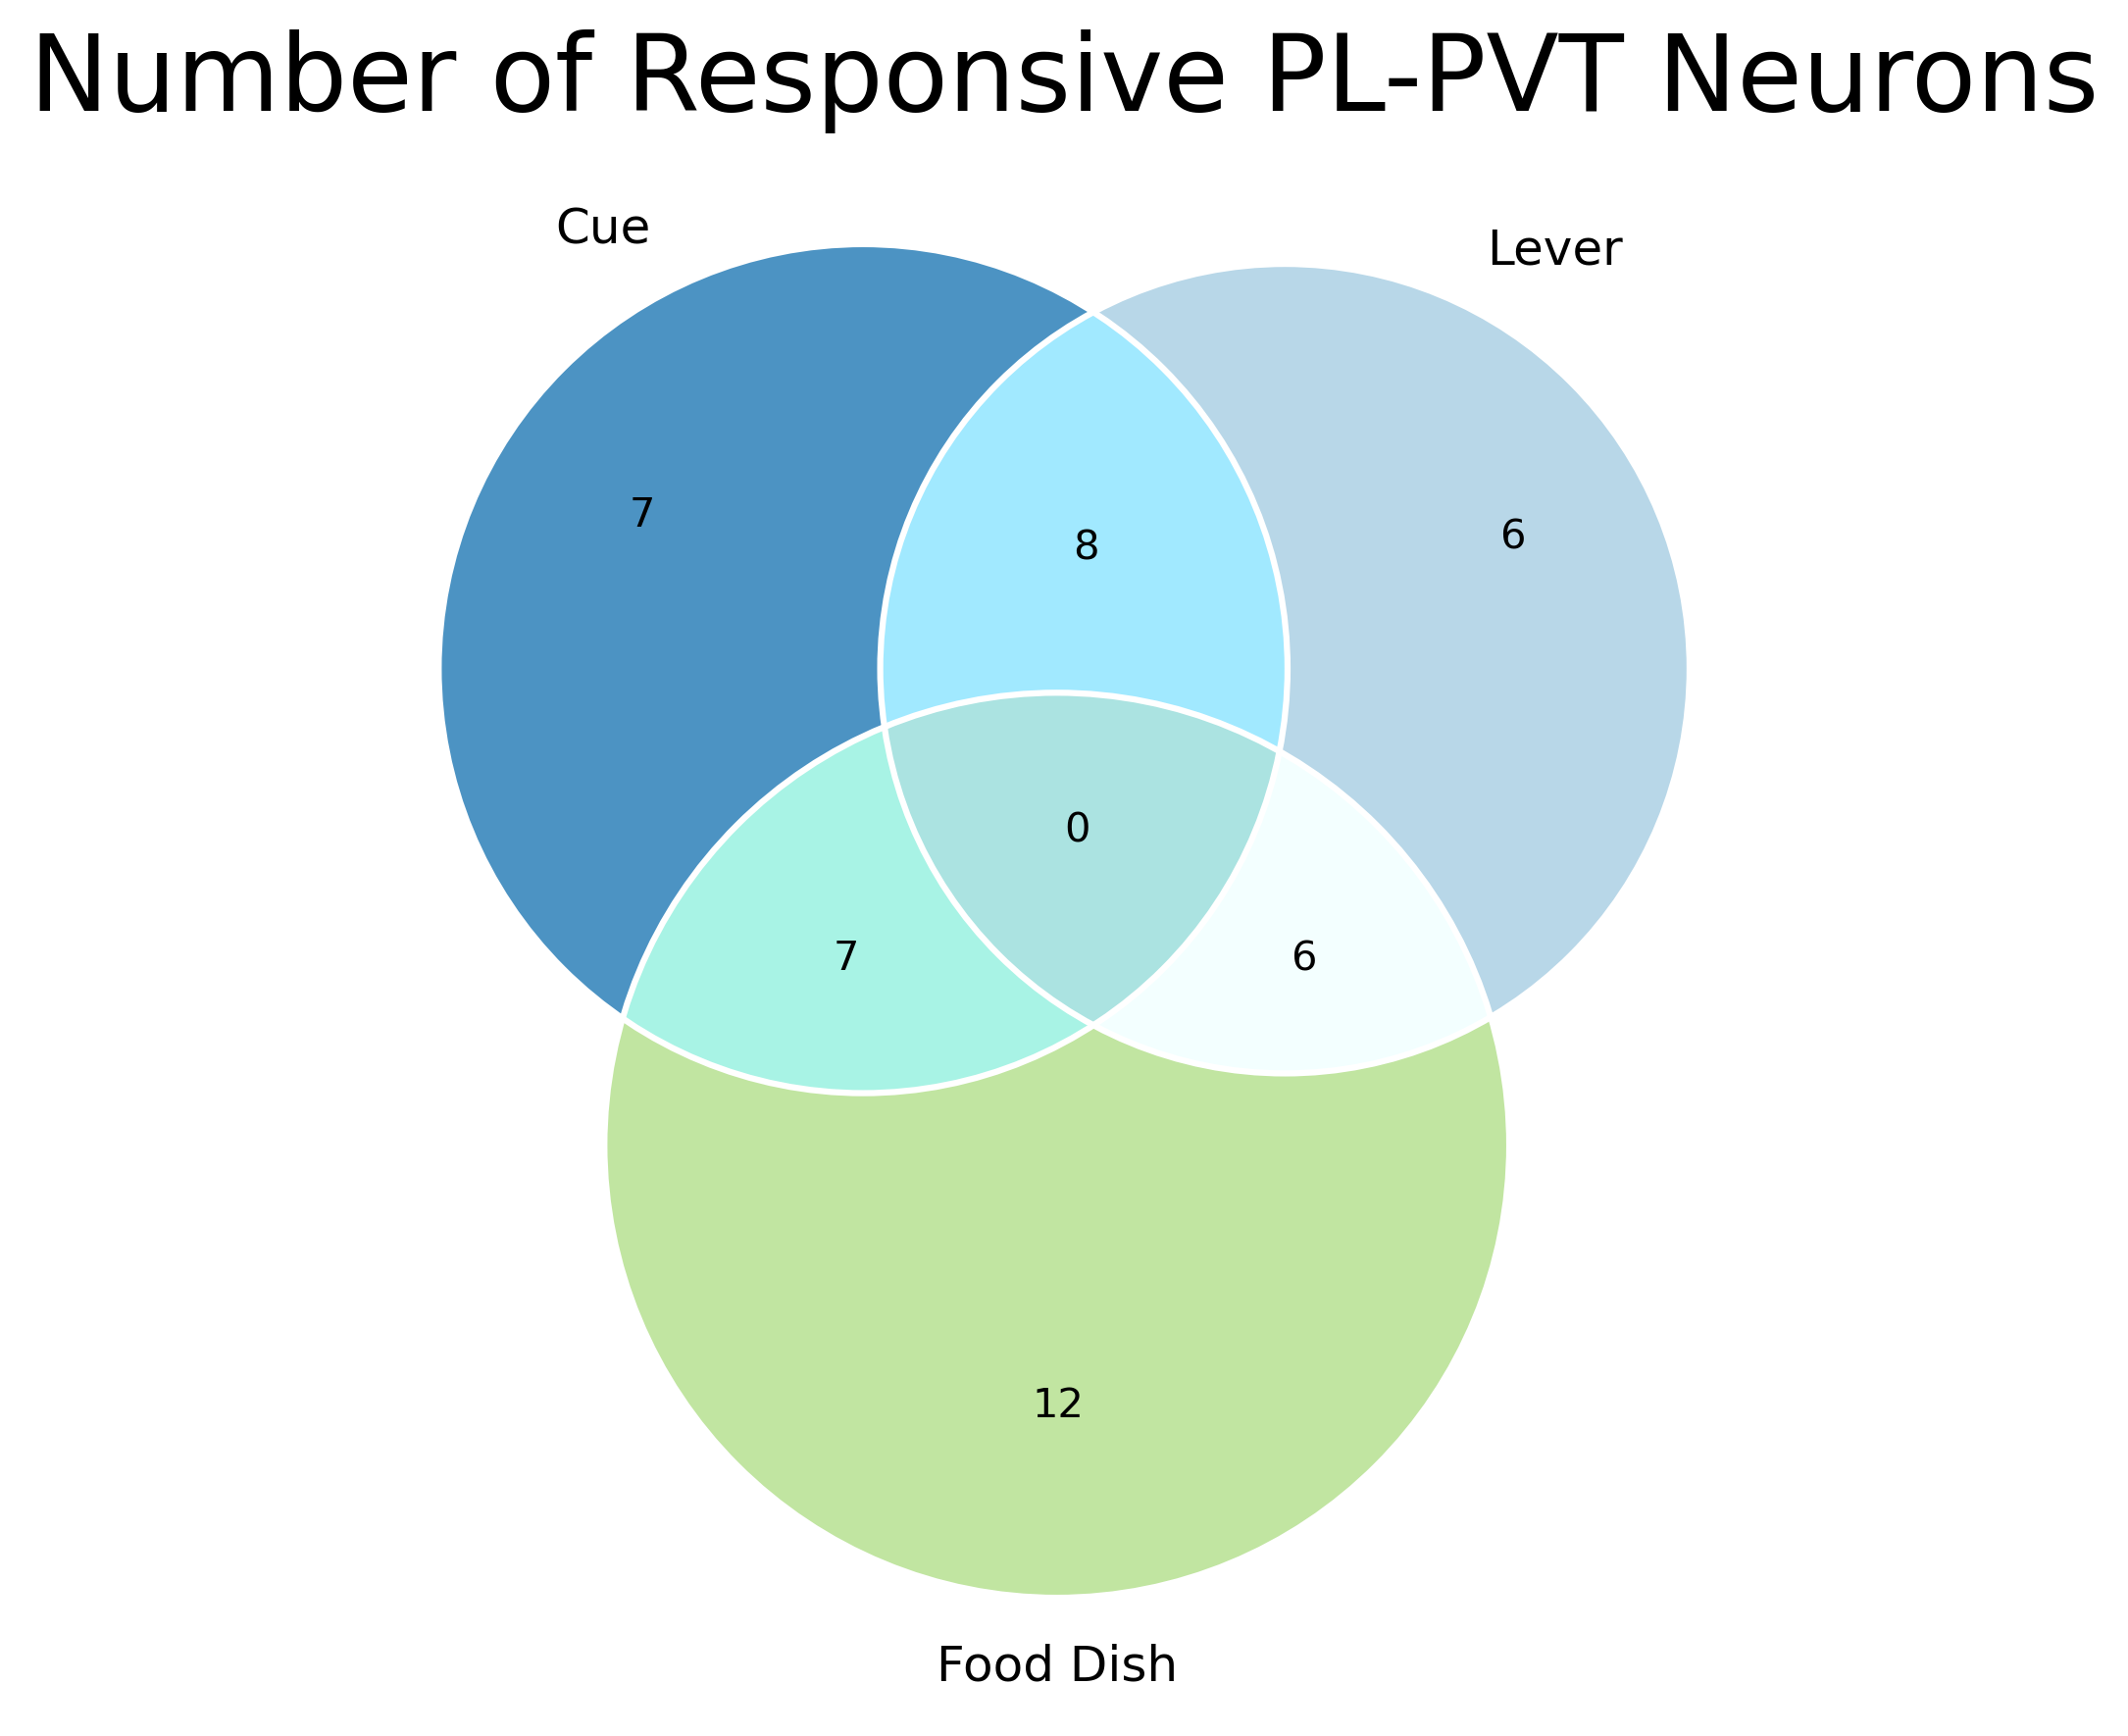

In [110]:
from matplotlib_venn import venn3,venn3_circles

plt.figure(figsize = (9,6),dpi = 300)
venn = venn3([set(cue_cells_pvt), set(lever_cells_pvt), set(headindish_cells_pvt)], ('Cue', 'Lever', 'Food Dish'), set_colors=(sns.color_palette('Paired')[1],
                                                                                                               sns.color_palette('Paired')[0],
                                                                                                               sns.color_palette('Paired')[2]),alpha=0.8)

# for text in venn.set_labels:
#     text.set_visible(False)

# for area in ['10', '01', '11']:
#     if venn.get_label_by_id(area) is not None:
#         venn.get_label_by_id(area).set_fontsize(22)
#         venn.get_label_by_id(area).set_color('black')
        
venn3_circles([set(cue_cells_pvt), set(lever_cells_pvt), set(headindish_cells_pvt)], color= 'white', lw = 1.5)

# legend_labels = ['Hungry Cues', 'Satiated Cues', 'Mixed']
# legend_colors = [venn.get_patch_by_id('10').get_facecolor(), 
#                  venn.get_patch_by_id('01').get_facecolor(), 
#                  venn.get_patch_by_id('11').get_facecolor()]

# legend_handles = [Patch(facecolor=color, label=label) for label, color in zip(legend_labels, legend_colors)]
# plt.legend(handles=legend_handles, ncol = 1, fontsize = 22,loc='lower center', frameon=False, bbox_to_anchor=(1.45,0.15))
plt.title('Number of Responsive PL-PVT Neurons', fontsize = 26)
plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/DB/output/PL_PVT_responsive.svg", transparent=True)

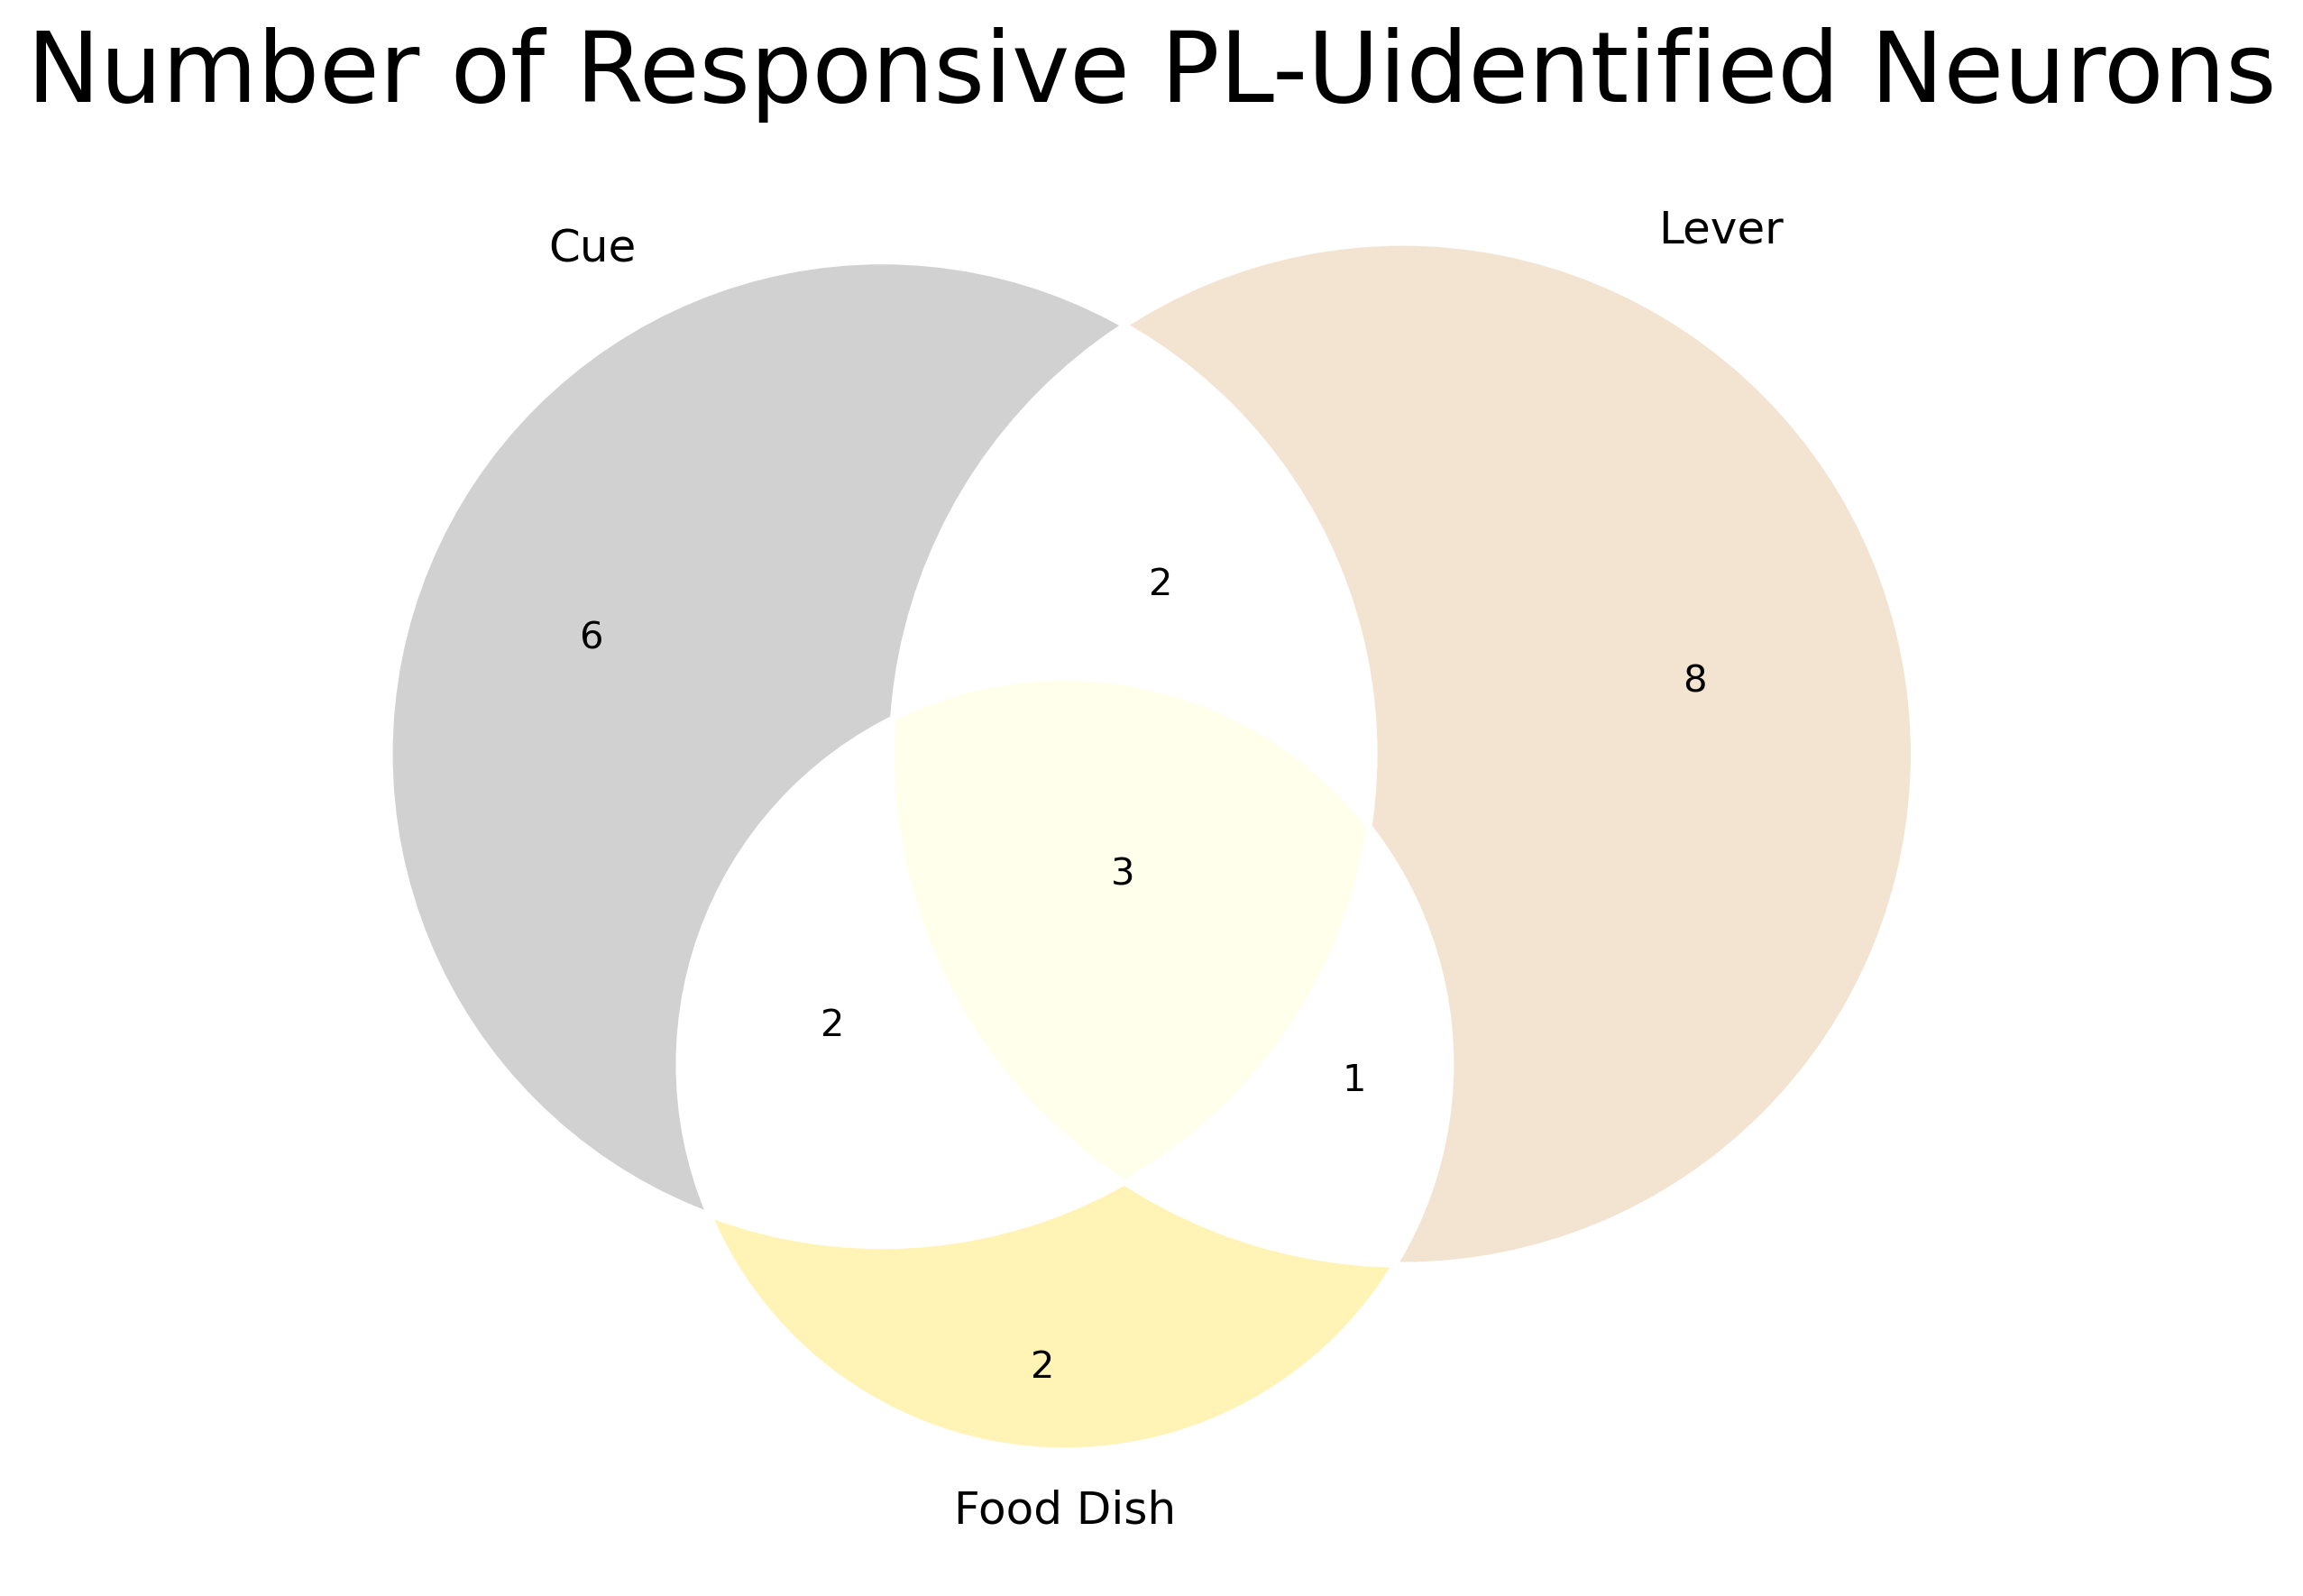

In [111]:
plt.figure(figsize = (9,6),dpi = 300)
venn = venn3([set(cue_cells_unidentified), set(lever_cells_unidentified), set(headindish_cells_unidentified)], ('Cue', 'Lever', 'Food Dish'), set_colors=(sns.color_palette('Pastel2')[-1],
                                                                                                               sns.color_palette('Pastel2')[-2],
                                                                                                               sns.color_palette('Pastel2')[-3]),alpha=0.9)

# for text in venn.set_labels:
#     text.set_visible(False)

# for area in ['10', '01', '11']:
#     if venn.get_label_by_id(area) is not None:
#         venn.get_label_by_id(area).set_fontsize(22)
#         venn.get_label_by_id(area).set_color('black')
        
venn3_circles([set(cue_cells_unidentified), set(lever_cells_unidentified), set(headindish_cells_unidentified)], color= 'white', lw = 1.5)

# legend_labels = ['Hungry Cues', 'Satiated Cues', 'Mixed']
# legend_colors = [venn.get_patch_by_id('10').get_facecolor(), 
#                  venn.get_patch_by_id('01').get_facecolor(), 
#                  venn.get_patch_by_id('11').get_facecolor()]

# legend_handles = [Patch(facecolor=color, label=label) for label, color in zip(legend_labels, legend_colors)]
# plt.legend(handles=legend_handles, ncol = 1, fontsize = 22,loc='lower center', frameon=False, bbox_to_anchor=(1.45,0.15))
plt.title('Number of Responsive PL-Uidentified Neurons', fontsize = 26)
plt.tight_layout()
plt.savefig("/scratch/09117/xz6783/Xu/DB/output/PL_unidentified_responsive.svg", transparent=True)